## IEEE competition fraud detection using boosting

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import random
seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
import eli5

/opt/conda/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future versi

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
%%time
train_transaction = pd.read_csv('../input/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')


# train_transaction = reduce_mem_usage(train_transaction)
# test_transaction = reduce_mem_usage(test_transaction)

sample_submission = pd.read_csv('../input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

CPU times: user 30.7 s, sys: 4.2 s, total: 34.9 s
Wall time: 35 s


In [4]:
train_transaction['hour'] = train_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
test_transaction['hour'] = test_transaction['TransactionDT'].map(lambda x:(x//3600)%24)
train_transaction['weekday'] = train_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)
test_transaction['weekday'] = test_transaction['TransactionDT'].map(lambda x:(x//(3600 * 24))%7)

In [5]:
cols = "TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(",")
train_test = train_transaction[cols].append(test_transaction[cols])

for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train_transaction[col+'_count'] = train_transaction[col].map(col_count)
    test_transaction[col+'_count'] = test_transaction[col].map(col_count)
#     print(col,test_transaction[col].map(lambda x:0 if x in s else 1).sum())


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train_transaction[col+'_amtcount'] = train_transaction[col].map(col_count)
    test_transaction[col+'_amtcount'] = test_transaction[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    train_transaction[col+'_C5count'] = train_transaction[col].map(col_count2) / (train_transaction[col].map(col_count1) + 0.01)
    test_transaction[col+'_C5count'] = test_transaction[col].map(col_count2) / (test_transaction[col].map(col_count1) + 0.01)
    
del train_test


In [6]:
train_identity = pd.read_csv('../input/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/ieee-fraud-detection/test_identity.csv', index_col='TransactionID')


# train_test = train_identity.append(test_identity).fillna(-1)    
# for col in "id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo".split(","):
#     col_count = train_test.groupby(col)['id_01'].count()
#     train_identity[col+'_count'] = train_identity[col].fillna(-1).map(col_count)
#     test_identity[col+'_count'] = test_identity[col].fillna(-1).map(col_count)
    
# del train_test

In [7]:

col_del = []
for i in range(339):
    col = "V" + str(i+1)
    s = train_transaction[col].fillna(0).map(lambda x:0 if x%1 == 0 else 1).sum()
    if s > 100:
        print(col,s)
        col_del.append(col)
#         del test_transaction[col],train_transaction[col]



V126 24875
V127 104743
V128 46447
V129 8376
V130 89202
V131 29537
V132 9116
V133 14910
V134 11134
V135 9184
V136 14824
V137 10682
V159 8116
V160 10836
V164 597
V165 3440
V166 2347
V202 16120
V203 20278
V204 18198
V205 6576
V206 4897
V207 9195
V208 10054
V209 10466
V210 10210
V211 10131
V212 11253
V213 10710
V214 4277
V215 5191
V216 4769
V263 16586
V264 20089
V265 18161
V266 6886
V267 10591
V268 8642
V270 8138
V271 8432
V272 8261
V273 10568
V274 11959
V275 11161
V276 4398
V277 5417
V278 4856
V306 37081
V307 140538
V308 67074
V309 16636
V310 121258
V311 10140
V312 46506
V313 50088
V314 59747
V315 51521
V316 15081
V317 24841
V318 18718
V319 10762
V320 18664
V321 13113


In [8]:
train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test

# Label Encoding
for f in X_train.columns:
    if X_train[f].dtype=='object' or X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(X_train[f].values) + list(X_test[f].values))
        X_train[f] = lbl.transform(list(X_train[f].values))
        X_test[f] = lbl.transform(list(X_test[f].values)) 

(590540, 468)
(506691, 467)


In [9]:
%%time
# From kernel https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
# WARNING! THIS CAN DAMAGE THE DATA 

X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

debug = False
if debug:
    split_pos = X_train.shape[0]*4//5
    y_test = y_train.iloc[split_pos:]
    y_train = y_train.iloc[:split_pos]
    X_test = X_train.iloc[split_pos:,:]
    X_train = X_train.iloc[:split_pos,:]

Memory usage of dataframe is 2128.56 MB
Memory usage after optimization is: 610.22 MB
Decreased by 71.3%
Memory usage of dataframe is 1809.17 MB
Memory usage after optimization is: 514.14 MB
Decreased by 71.6%
CPU times: user 1min 55s, sys: 5min 54s, total: 7min 50s
Wall time: 7min 50s


In [10]:
import gc
gc.collect()

60

In [11]:
%%time

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds = np.zeros(X_test.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=700,
        max_depth=9,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr = X_train.iloc[tr_idx, :]
    y_tr = y_train.iloc[tr_idx]
    clf.fit(X_tr, y_tr)
    del X_tr
    y_preds+= clf.predict_proba(X_test)[:,1] / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test)[:,1] / folds)) 
    del clf
        
    

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  

gc.collect()

CPU times: user 1min 5s, sys: 2min 1s, total: 3min 6s
Wall time: 3min 7s


86

In [12]:
features = [x for x in X_train.columns if x not in col_del]
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds11 = np.zeros(X_test.shape[0])
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):
    i+=1
    clf = xgb.XGBClassifier(
        n_estimators=850,
        max_depth=10,
        learning_rate=0.03,
        subsample=0.9,
        colsample_bytree=0.9,
        tree_method='gpu_hist'
    )
    
    X_tr = X_train[features].iloc[tr_idx, :]
    y_tr = y_train.iloc[tr_idx]
    clf.fit(X_tr, y_tr)
    del X_tr
    y_preds11+= clf.predict_proba(X_test[features])[:,1] / folds
    if debug:    
        print("debug:",roc_auc_score(y_test, clf.predict_proba(X_test[features])[:,1] / folds))   
    del clf    
    
gc.collect()
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds11))  
    print("debug:",roc_auc_score(y_test, y_preds11*0.5 + y_preds*0.5))

In [13]:
import lightgbm as lgb
cate = [x for x in X_train.columns if (x == 'ProductCD' or  x.startswith("addr") or x.startswith("card") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") ]
print(cate)
params = {'application': 'binary',
          'boosting': 'gbdt',
          'metric': 'roc',
          'max_depth': 16,
          'learning_rate': 0.05,
          'bagging_fraction': 0.9,
          'feature_fraction': 0.9,
          'verbosity': -1,
          'lambda_l1': 0.1,
          'lambda_l2': 0.01,
          'num_leaves': 550,
          'min_child_weight': 3,
          'data_random_seed': 17,
         'nthreads':4}

early_stop = 500
verbose_eval = 30
num_rounds = 600
# 
folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
y_preds2 = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr = X_train.iloc[tr_idx, :]
    y_tr = y_train.iloc[tr_idx]
    d_train = lgb.Dataset(X_tr, label=y_tr,categorical_feature = cate)
    watchlist = []
    if debug:
        d_test = lgb.Dataset(X_test, label=y_test,categorical_feature = cate)
        watchlist.append(d_test)
    
    
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval)
        
    
    y_preds2+= model.predict(X_test) / folds
    
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = X_tr.columns
    fold_importance_df["importance"] = model.feature_importance()
    fold_importance_df["fold"] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict(X_test) / folds))  
    i+=1
    del X_tr,d_train

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5))  




['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [14]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))  
    print("debug:",roc_auc_score(y_test, y_preds2))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2)*0.5)) 

Index(['TransactionDT', 'card1', 'TransactionAmt', 'card1_count', 'hour',
       'addr1', 'weekday', 'D15', 'id_02', 'addr1_count', 'D4', 'dist1',
       'card1_C5count', 'card2_count', 'card2', 'card1_amtcount',
       'addr1_C5count', 'addr1_amtcount', 'id_20', 'D10', 'id_19',
       'card2_C5count', 'D2', 'D8', 'C13', 'D11', 'id_31', 'card2_amtcount',
       'C13_count', 'D1', 'D5', 'C1', 'D3', 'id_13', 'id_06', 'C14_count',
       'DeviceInfo', 'dist2', 'P_emaildomain', 'M4', 'C2', 'id_05', 'V307',
       'D9', 'id_01', 'C1_count', 'C6_count', 'M6', 'D14', 'card5_count',
       'C14', 'C11', 'C6', 'card5_C5count', 'card5_amtcount', 'M5', 'C2_count',
       'V313', 'V310', 'C11_count', 'C9_count', 'V45', 'V127', 'id_33', 'D6',
       'C9', 'D12', 'id_18', 'V308', 'M8', 'V264', 'M7', 'V87', 'V315',
       'DeviceType', 'V130', 'V75', 'V76', 'id_30', 'V35', 'V317', 'V314',
       'V78', 'V38', 'V53', 'C8', 'V54', 'D13', 'V83', 'V62', 'id_14', 'V12',
       'C10', 'V44', 'R_emaildomain

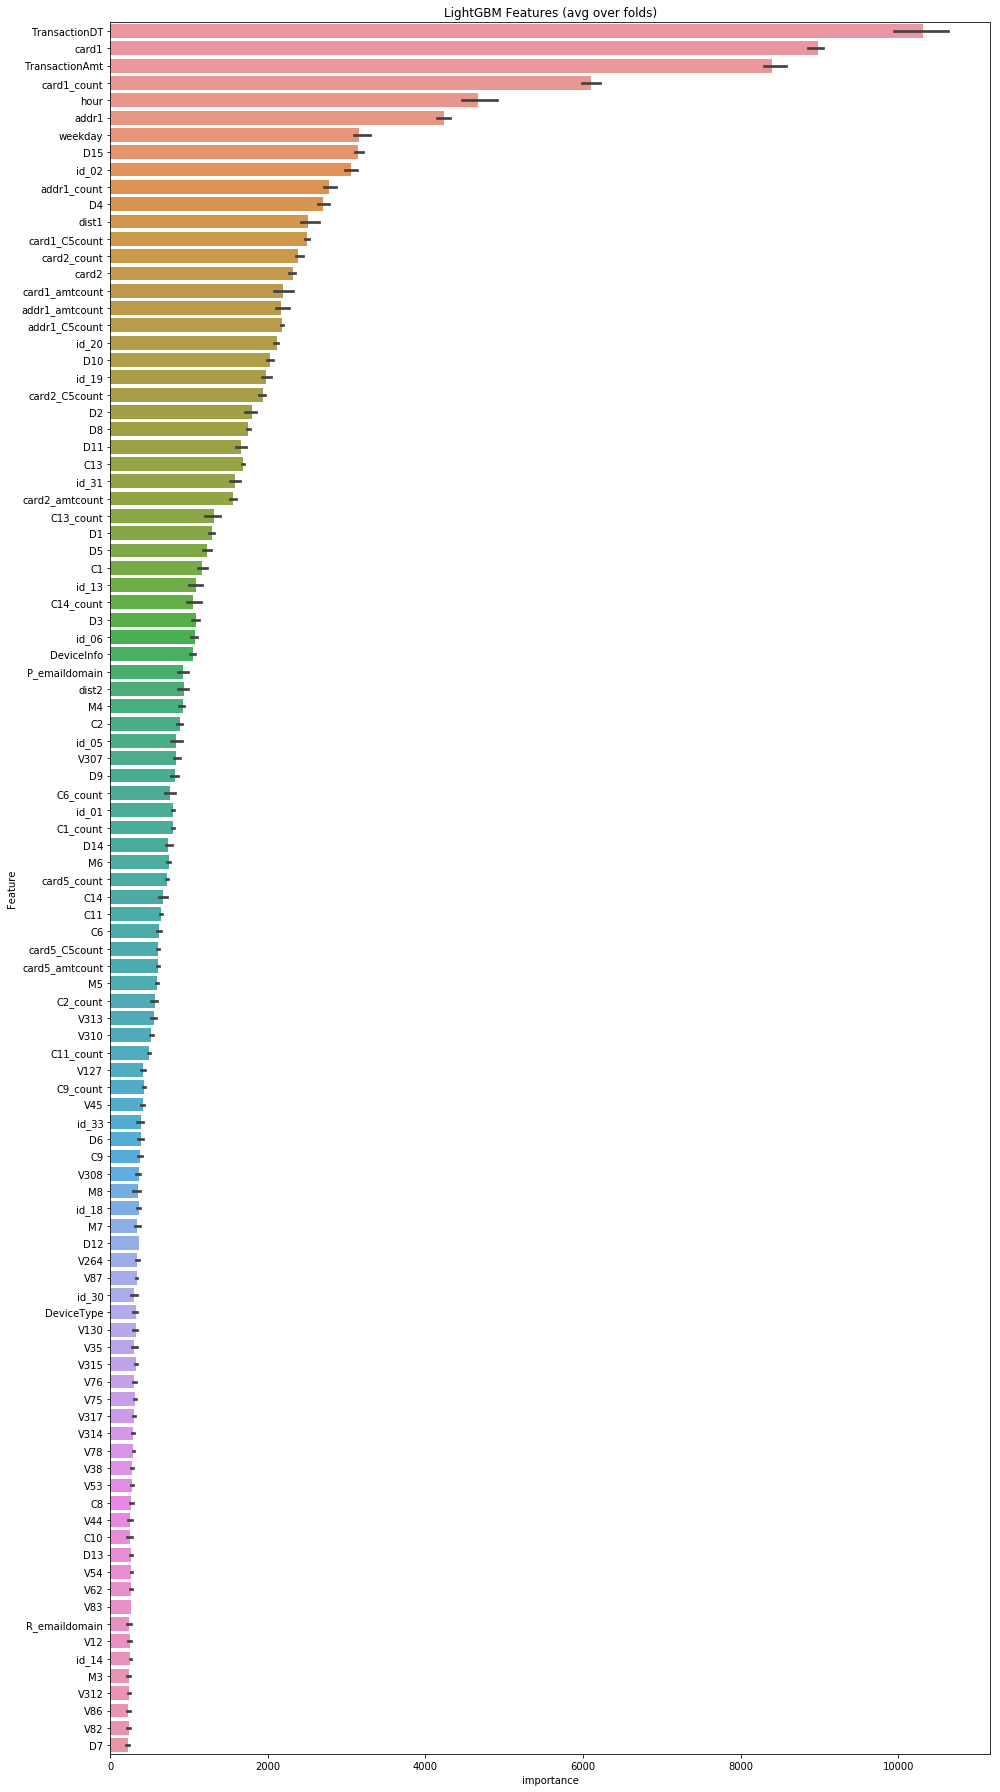

In [15]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:100].index)
print(cols)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [16]:
import catboost as cb
from catboost import CatBoostClassifier,Pool


features = [x for x in X_train.columns]

cate = [x for x in X_train.columns if (x == 'ProductCD' or x in ['card1','card2'] or x.startswith("addr") or 
                                       x.endswith("domain") or x.startswith("Device")) and not x.endswith("count") and not x == "id_11" ]

# cate = []
print(cate)
verbose_eval = 30
num_rounds = 800

folds = 3
kf = KFold(n_splits = folds, shuffle = True, random_state=seed+1)
y_preds3 = np.zeros(X_test.shape[0])
feature_importance_df = pd.DataFrame()
i = 0
for tr_idx, val_idx in kf.split(X_train, y_train):

    
    X_tr = X_train[features].iloc[tr_idx, :].fillna(-1)
    y_tr = y_train.iloc[tr_idx]
    
    model=cb.CatBoostClassifier(iterations=num_rounds,depth=14,learning_rate=0.04,loss_function='Logloss',eval_metric='Logloss'
                                ,task_type = "GPU")
    if debug:
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
    else:
        model.fit(X_tr,y_tr,cat_features=cate,verbose_eval = 30)
        

    del X_tr
    y_preds3+= model.predict_proba(X_test[features].fillna(-1))[:,1] / folds
    
    
    if debug:    
        print("debug:",roc_auc_score(y_test, model.predict_proba(X_test[features].fillna(-1))[:,1] / folds))  
    i+=1

if debug:    
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3)*0.33))

['ProductCD', 'card1', 'card2', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
0:	learn: 0.6160710	total: 1.48s	remaining: 19m 44s
30:	learn: 0.0931425	total: 44.9s	remaining: 18m 33s
60:	learn: 0.0658641	total: 1m 29s	remaining: 17m 59s
90:	learn: 0.0583182	total: 2m 12s	remaining: 17m 15s
120:	learn: 0.0532428	total: 2m 56s	remaining: 16m 31s
150:	learn: 0.0497832	total: 3m 40s	remaining: 15m 47s
180:	learn: 0.0474022	total: 4m 24s	remaining: 15m 2s
210:	learn: 0.0459087	total: 5m 7s	remaining: 14m 17s
240:	learn: 0.0442951	total: 5m 50s	remaining: 13m 33s
270:	learn: 0.0432689	total: 6m 33s	remaining: 12m 49s
300:	learn: 0.0418035	total: 7m 17s	remaining: 12m 4s
330:	learn: 0.0407762	total: 8m	remaining: 11m 21s
360:	learn: 0.0397597	total: 8m 44s	remaining: 10m 37s
390:	learn: 0.0388190	total: 9m 27s	remaining: 9m 53s
420:	learn: 0.0377432	total: 10m 10s	remaining: 9m 9s
450:	learn: 0.0367218	total: 10m 54s	remaining: 8m 26s
480:	learn: 0.0358998	to

In [17]:
if debug:    
    print("debug:",roc_auc_score(y_test, y_preds))
    print("debug:",roc_auc_score(y_test, y_preds2))
    print("debug:",roc_auc_score(y_test, y_preds3))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds3)*0.5))  
    print("debug:",roc_auc_score(y_test, (y_preds + y_preds2 + y_preds3*0.5)*0.33))
    print("debug:",roc_auc_score(y_test, (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33))

In [18]:
if not debug:   
    sample_submission['isFraud'] = (y_preds11*0.5 + y_preds*0.5 + y_preds2 + y_preds3*0.5)*0.33
    sample_submission.to_csv('simple_ensemble6.csv')
